<h1 align="center"><font size="5"> Project: Loan Default Prediction of Landing Club </font></h1>

## Table of Contents

- [1. Data Manipulation](#1-data-manipulation)
  - [Data Cleaning](#data-cleaning)
  - [Feature Selection](#feature-selection)
  - [Selection Data by Year](#selection-data-by-year)
- [2. Exploratory Data Analysis - EDA](#2-exploratory-data-analysis---eda)
  - [Missing Value](#missing-value)
  - [Data Info](#data-info)
  - [Catagorical Variables](#catagorical-variables)
    - [term](#term)
    - [grade](#grade)
    - [home_ownership](#home_ownership)
    - [verification_status](#verification_status)
    - [purpose](#purpose)
    - [addr_state](#addr_state)
  - [Numerical Variables](#numerical-variables)
  - [Transfer catagorical variables to dummy variables](#transfer-catagorical-variables-to-dummy-variables)
  - [Split the Data & Standardization - Feature Scaling](#split-the-data--standardization---feature-scaling)
- [3. Modeling](#3-modeling)
  - [Random Forest](#random-forest)
    - [RF Cross-Validation](#rf-cross-validation)
    - [RF Result](#rf-result)
  - [Neural Network](#neural-network)
    - [NN Cross-Validation](#nn-cross-validation)
    - [NN Result](#nn-result)
  - [Logistic Regression](#logistic-regression)
    - [Implementing the model](#implementing-the-model)
    - [Logistic Regression](#logistic-regression-1)
    - [Log Cross-Validation](#log-cross-validation)
    - [Log Result](#log-result)
  - [SVM -- LinearSVC (linear kernel)](#svm----linearsvc-linear-kernel)
    - [SVM Cross-Validation](#svm-cross-validation)
    - [SVM Result](#svm-result)
  - [KNN](#knn)
    - [KNN Cross-Validation](#knn-cross-validation)
    - [KNN Result](#knn-result)
    - [Application](#application)


## 1. Data Manipulation

In [183]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [184]:
# loading data
# data from https://www.kaggle.com/wordsforthewise/lending-club
data = pd.read_csv("accepted_2007_to_2018Q4.csv")

/var/folders/bz/l7r0xzzj7vl0dql5wgb8n24m0000gn/T/ipykernel_28062/3648902232.py:3: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("accepted_2007_to_2018Q4.csv")


In [185]:
data.shape

(2260701, 151)

### Data Cleaning

We find that there are 151, so we first check Nan for each variable

In [186]:
# ranking - the number of NaN values
rank_nan = data.isnull().sum().to_frame()
# the percentage of NaN
precent_nan = [round(i/2260701,4) for i in rank_nan[0]] 
# add precent_nan to rank_nan
rank_nan["precent_nan"] = precent_nan

In [187]:
rank_nan.sort_values(by=0,ascending=True)

,0,precent_nan
id,0,0.0000
fico_range_high,33,0.0000
hardship_flag,33,0.0000
revol_bal,33,0.0000
initial_list_status,33,0.0000
...,...,...
hardship_reason,2249784,0.9952
hardship_dpd,2249784,0.9952
hardship_loan_status,2249784,0.9952
orig_projected_additional_accrued_interest,2252050,0.9962


In [188]:
rank_nan["precent_nan"].describe()

count    151.000000
mean       0.317794
std        0.416366
min        0.000000
25%        0.000000
50%        0.031100
75%        0.892650
max        1.000000
Name: precent_nan, dtype: float64

In [189]:
rank_nan[rank_nan["precent_nan"] > 0.1].count()

0              59
precent_nan    59
dtype: int64

We find that there are 59 out of 151 variables has more than 10% Nan values

### Feature Selection


In [190]:
# only keep Fully Paid and Charged Off for loan_status(y)
df = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})
df = df.drop('loan_status', axis = 1)

/var/folders/bz/l7r0xzzj7vl0dql5wgb8n24m0000gn/T/ipykernel_28062/2508452534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})


In [191]:
# y label
y_label = ['loan_repaid']
# catagorical labels
cata_labels = ['term','grade','home_ownership','verification_status','purpose','addr_state']

In [192]:
# numerical labels
num_labels = ['loan_amnt','int_rate','installment','annual_inc','open_acc','pub_rec','revol_bal','revol_util',
                        'total_acc','pub_rec_bankruptcies', 'last_fico_range_high','issue_d']
#last_pymnt_amnt
labels = y_label + cata_labels + num_labels
labels

['loan_repaid',
 'term',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'pub_rec_bankruptcies',
 'last_fico_range_high',
 'issue_d']

In [193]:
# redefine df
df = df[labels]

### Selection Data by Year

/var/folders/bz/l7r0xzzj7vl0dql5wgb8n24m0000gn/T/ipykernel_28062/1713045967.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.issue_d = pd.to_datetime(df.issue_d)


<Axes: ylabel='Frequency'>

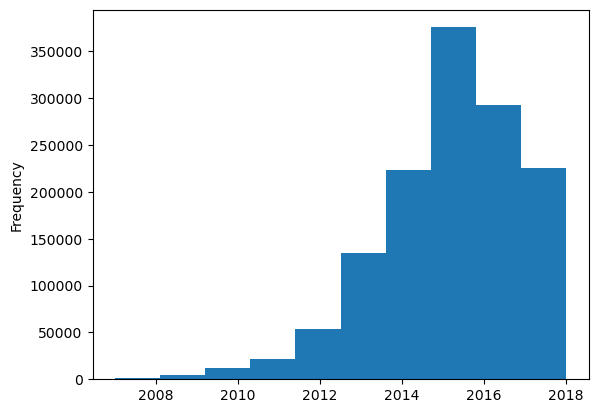

In [194]:
df.issue_d = pd.to_datetime(df.issue_d)
df['issue_yr'] = df.issue_d.dt.year
df['issue_yr'].plot.hist()

In [195]:
df['issue_yr'].value_counts()

issue_yr
2015    375545
2016    293095
2014    223102
2017    169300
2013    134804
2018     56311
2012     53367
2011     21721
2010     11536
2009      4716
2008      1562
2007       251
Name: count, dtype: int64

In [196]:
df.head()

,loan_repaid,term,grade,home_ownership,verification_status,purpose,addr_state,loan_amnt,int_rate,installment,annual_inc,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,last_fico_range_high,issue_d,issue_yr
0,1,36 months,C,MORTGAGE,Not Verified,debt_consolidation,PA,3600.0,13.99,123.03,55000.0,7.0,0.0,2765.0,29.7,13.0,0.0,564.0,2015-12-01,2015
1,1,36 months,C,MORTGAGE,Not Verified,small_business,SD,24700.0,11.99,820.28,65000.0,22.0,0.0,21470.0,19.2,38.0,0.0,699.0,2015-12-01,2015
2,1,60 months,B,MORTGAGE,Not Verified,home_improvement,IL,20000.0,10.78,432.66,63000.0,6.0,0.0,7869.0,56.2,18.0,0.0,704.0,2015-12-01,2015
4,1,60 months,F,MORTGAGE,Source Verified,major_purchase,PA,10400.0,22.45,289.91,104433.0,12.0,0.0,21929.0,64.5,35.0,0.0,704.0,2015-12-01,2015
5,1,36 months,C,RENT,Source Verified,debt_consolidation,GA,11950.0,13.44,405.18,34000.0,5.0,0.0,8822.0,68.4,6.0,0.0,759.0,2015-12-01,2015


In [197]:
df = df[df['issue_yr'] == 2018.0].drop(['issue_yr','issue_d'], axis = 1)

In [198]:
df.head()

,loan_repaid,term,grade,home_ownership,verification_status,purpose,addr_state,loan_amnt,int_rate,installment,annual_inc,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,last_fico_range_high
421101,1,36 months,A,RENT,Source Verified,major_purchase,WA,3000.0,7.34,93.10,52000.0,7.0,0.0,141.0,0.5,30.0,0.0,764.0
421113,1,36 months,B,OWN,Not Verified,other,GA,5000.0,11.98,166.03,55000.0,14.0,1.0,11449.0,33.9,24.0,1.0,679.0
421120,1,36 months,B,MORTGAGE,Verified,home_improvement,TX,7000.0,11.98,232.44,40000.0,13.0,0.0,5004.0,36.0,29.0,0.0,644.0
421135,1,36 months,D,OWN,Verified,debt_consolidation,FL,30000.0,21.85,1143.39,57000.0,11.0,0.0,29222.0,53.2,26.0,0.0,699.0
421137,1,60 months,D,OWN,Source Verified,house,NY,21000.0,20.39,560.94,85000.0,15.0,0.0,14591.0,34.2,27.0,0.0,659.0


## 2. Exploratory Data Analysis - EDA

### Missing Value

In [199]:
# Checking the missing values
df.isnull().sum()

loan_repaid              0
term                     0
grade                    0
home_ownership           0
verification_status      0
purpose                  0
addr_state               0
loan_amnt                0
int_rate                 0
installment              0
annual_inc               0
open_acc                 0
pub_rec                  0
revol_bal                0
revol_util              74
total_acc                0
pub_rec_bankruptcies     0
last_fico_range_high     0
dtype: int64

In [200]:
# data cleaning
df = df.dropna()

In [201]:
df.isnull().sum()

loan_repaid             0
term                    0
grade                   0
home_ownership          0
verification_status     0
purpose                 0
addr_state              0
loan_amnt               0
int_rate                0
installment             0
annual_inc              0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
pub_rec_bankruptcies    0
last_fico_range_high    0
dtype: int64

### Data Info

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56237 entries, 421101 to 1611872
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_repaid           56237 non-null  int64  
 1   term                  56237 non-null  object 
 2   grade                 56237 non-null  object 
 3   home_ownership        56237 non-null  object 
 4   verification_status   56237 non-null  object 
 5   purpose               56237 non-null  object 
 6   addr_state            56237 non-null  object 
 7   loan_amnt             56237 non-null  float64
 8   int_rate              56237 non-null  float64
 9   installment           56237 non-null  float64
 10  annual_inc            56237 non-null  float64
 11  open_acc              56237 non-null  float64
 12  pub_rec               56237 non-null  float64
 13  revol_bal             56237 non-null  float64
 14  revol_util            56237 non-null  float64
 15  total_acc        

<span style='color:Blue'> We have 6 catagorical variables and 13 numerical variables. 

### Catagorical Variables

In [203]:
df.select_dtypes(['object']).columns

Index(['term', 'grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state'],
      dtype='object')

### term

In [204]:
# term
df['term'].value_counts()

term
36 months    41209
60 months    15028
Name: count, dtype: int64

In [205]:
df['term'] = df['term'].apply(lambda term: int(term[:3])) # term[:3] take first 3 values

In [206]:
df['term'].value_counts()

term
36    41209
60    15028
Name: count, dtype: int64

<span style='color:Blue'> We change variable term from catagorical to numerical

### grade

In [207]:
# grade
df['grade'].value_counts(normalize=True)

grade
B    0.270551
C    0.261998
A    0.227750
D    0.171613
E    0.053808
F    0.011736
G    0.002543
Name: proportion, dtype: float64

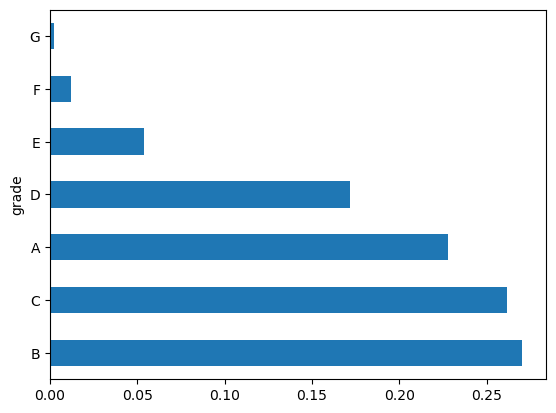

In [208]:
#plot the bar graph of percentage job categories
df['grade'].value_counts(normalize=True).plot.barh()
plt.show()

<Axes: xlabel='grade', ylabel='count'>

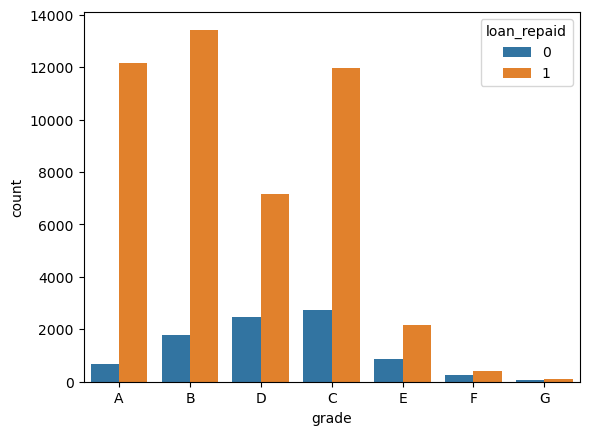

In [209]:
sns.countplot(x='grade',data=df,hue='loan_repaid')

In [210]:
# find % 0/1+0 in each grade
g0 = df[df['loan_repaid']==0].groupby("grade").count()['loan_repaid']
g1 = df.groupby("grade").count()['loan_repaid']
g = g0/g1
g

grade
A    0.051530
B    0.117121
C    0.186440
D    0.257797
E    0.290813
F    0.363636
G    0.391608
Name: loan_repaid, dtype: float64

<span style='color:Blue'> We find that there are 45%+ charge off in Grade F and G; Grade is a valuable factor

### home_ownership

In [211]:
df['home_ownership'].value_counts(normalize=False)

home_ownership
MORTGAGE    28487
RENT        20219
OWN          7508
ANY            23
Name: count, dtype: int64

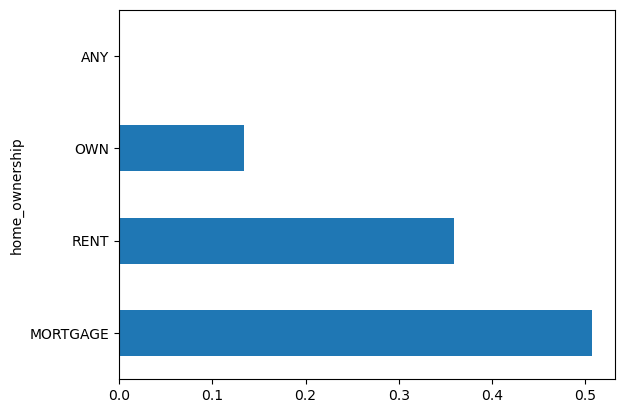

In [212]:
#plot the bar graph of percentage job categories
df['home_ownership'].value_counts(normalize=True).plot.barh()
plt.show()

In [213]:
df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY'],'OTHER')

In [214]:
df['home_ownership'].value_counts(normalize=False)

home_ownership
MORTGAGE    28487
RENT        20219
OWN          7508
OTHER          23
Name: count, dtype: int64

### verification_status

In [215]:
df['verification_status'].value_counts(normalize=False)

verification_status
Source Verified    22513
Not Verified       20993
Verified           12731
Name: count, dtype: int64

<Axes: xlabel='verification_status', ylabel='count'>

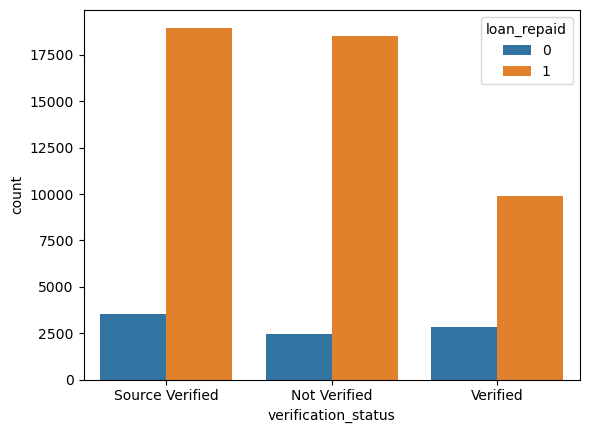

In [216]:
sns.countplot(x='verification_status',data=df,hue='loan_repaid')

In [217]:
# find % 0/1+0 in each grade
v0 = df[df['loan_repaid']==0].groupby("verification_status").count()['loan_repaid']
v1 = df.groupby("verification_status").count()['loan_repaid']
v = v0/v1
v

verification_status
Not Verified       0.117182
Source Verified    0.157465
Verified           0.223706
Name: loan_repaid, dtype: float64

<span style='color:Blue'> The Not Verified users has higher charge off rate

### purpose

In [218]:
df['purpose'].value_counts(normalize=False)

purpose
debt_consolidation    28699
credit_card           11388
other                  5383
home_improvement       4514
major_purchase         1804
medical                1031
house                   996
car                     774
small_business          569
vacation                533
moving                  507
renewable_energy         37
wedding                   2
Name: count, dtype: int64

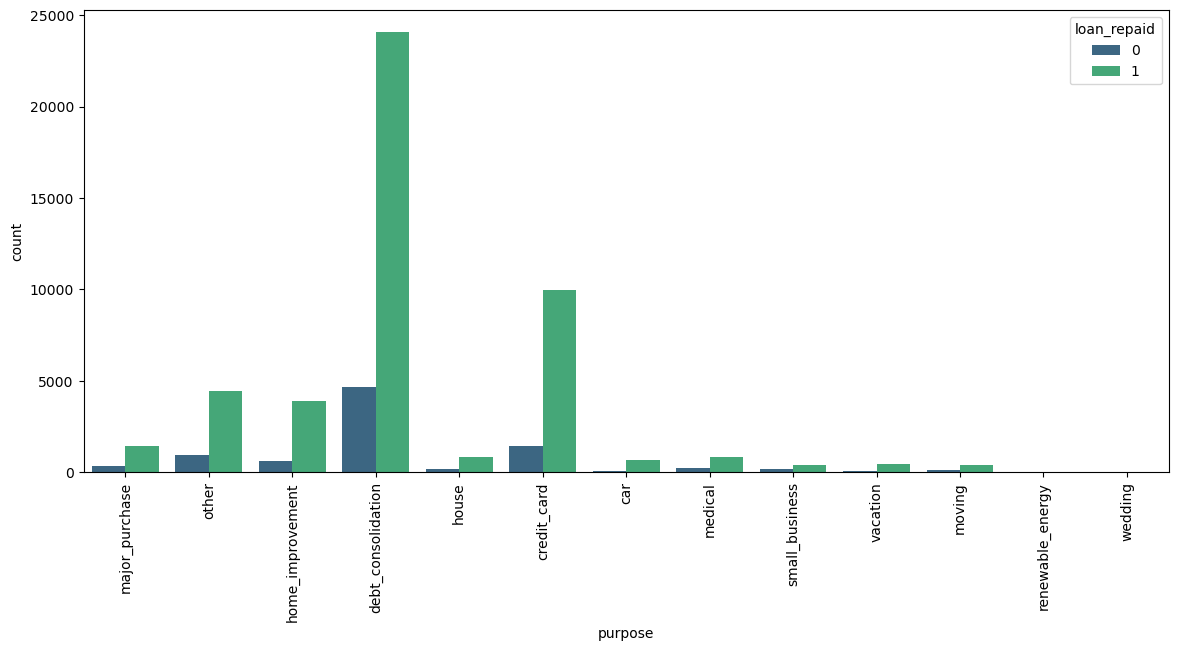

In [219]:
plt.figure(figsize=(14,6))
sns.countplot(data=df,x='purpose', hue='loan_repaid', palette='viridis');
plt.xticks(rotation=90);

In [220]:
# find % 0/1+0 in each purpose
p0 = df[df['loan_repaid']==0].groupby("purpose").count()['loan_repaid']
p1 = df.groupby("purpose").count()['loan_repaid']
p = p0/p1
p.sort_values()

purpose
car                   0.120155
credit_card           0.123639
home_improvement      0.140009
debt_consolidation    0.161469
renewable_energy      0.162162
vacation              0.170732
house                 0.178715
other                 0.178897
major_purchase        0.193459
medical               0.205626
moving                0.207101
small_business        0.318102
wedding               0.500000
Name: loan_repaid, dtype: float64

### addr_state

In [221]:
df['addr_state'].value_counts()

addr_state
CA    8207
TX    4599
FL    4330
NY    4130
IL    1836
GA    1784
NJ    1768
PA    1763
NC    1637
OH    1631
AZ    1526
MI    1513
VA    1499
CO    1477
MD    1348
WA    1332
MA    1331
NV    1091
MN     972
IN     937
TN     894
MO     858
WI     751
SC     747
CT     743
OR     682
AL     662
LA     559
UT     538
OK     531
KY     508
KS     382
AR     377
MS     324
NM     284
NE     269
WV     264
NH     257
HI     250
ID     250
RI     244
MT     168
DE     164
ME     158
DC     122
ND     117
VT     116
SD     112
WY     101
AK      94
Name: count, dtype: int64

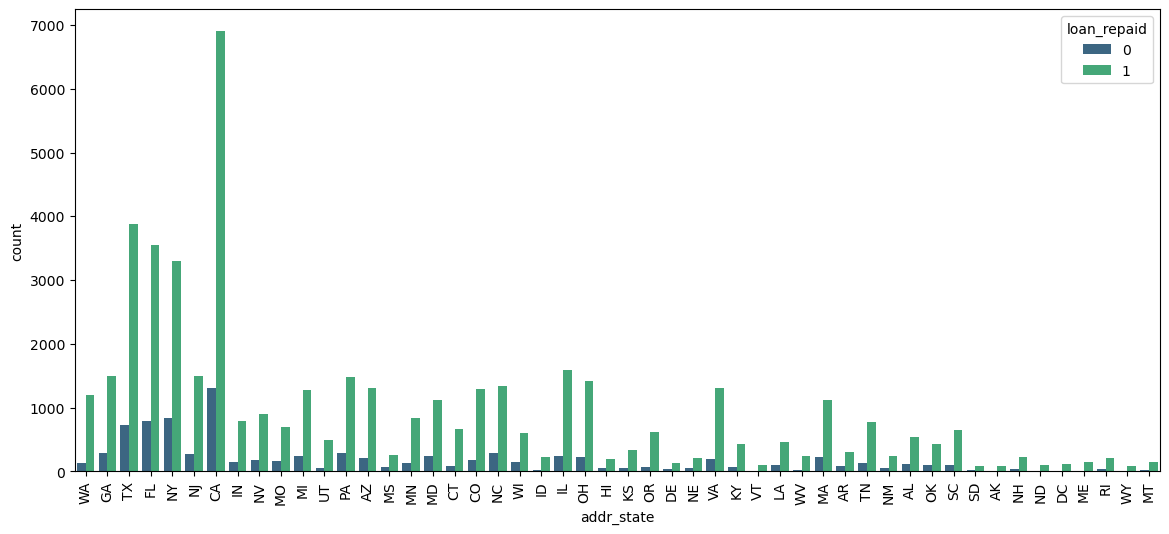

In [222]:
plt.figure(figsize=(14,6))
sns.countplot(data=df,x='addr_state', hue='loan_repaid', palette='viridis');
plt.xticks(rotation=90);

In [223]:
# find % 0/1+0 in each states
s0 = df[df['loan_repaid']==0].groupby("addr_state").count()['loan_repaid']
s1 = df.groupby("addr_state").count()['loan_repaid']
s = s0/s1
s.sort_values()

addr_state
ME    0.050633
UT    0.083643
ID    0.084000
VT    0.086207
WV    0.090909
DC    0.098361
WY    0.099010
OR    0.099707
WA    0.103604
ND    0.111111
MT    0.113095
CT    0.114401
RI    0.118852
CO    0.120515
VA    0.125417
NH    0.128405
SC    0.128514
IL    0.132898
OH    0.133047
AK    0.138298
KS    0.138743
MN    0.139918
TN    0.140940
AZ    0.141547
KY    0.141732
IN    0.150480
NJ    0.151018
TX    0.158078
CA    0.159132
MI    0.161930
NM    0.161972
PA    0.162223
MA    0.164538
GA    0.165359
NV    0.168653
MD    0.173591
AL    0.175227
NC    0.178375
OK    0.178908
FL    0.181293
DE    0.182927
LA    0.187835
MO    0.193473
HI    0.196000
WI    0.197071
NY    0.201937
MS    0.206790
AR    0.209549
SD    0.214286
NE    0.219331
Name: loan_repaid, dtype: float64

/var/folders/bz/l7r0xzzj7vl0dql5wgb8n24m0000gn/T/ipykernel_28062/3611505746.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/var/folders/bz/l7r0xzzj7vl0dql5wgb8n24m0000gn/T/ipykernel_28062/3611505746.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/var/folders/bz/l7r0xzzj7vl0dql5wgb8n24m0000gn/T/ipykernel_28062/3611505746.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
/var/folders/bz/l7r0xzzj7vl0dql5wgb8n24m0000gn/T/ipykernel_28062/3611505746.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

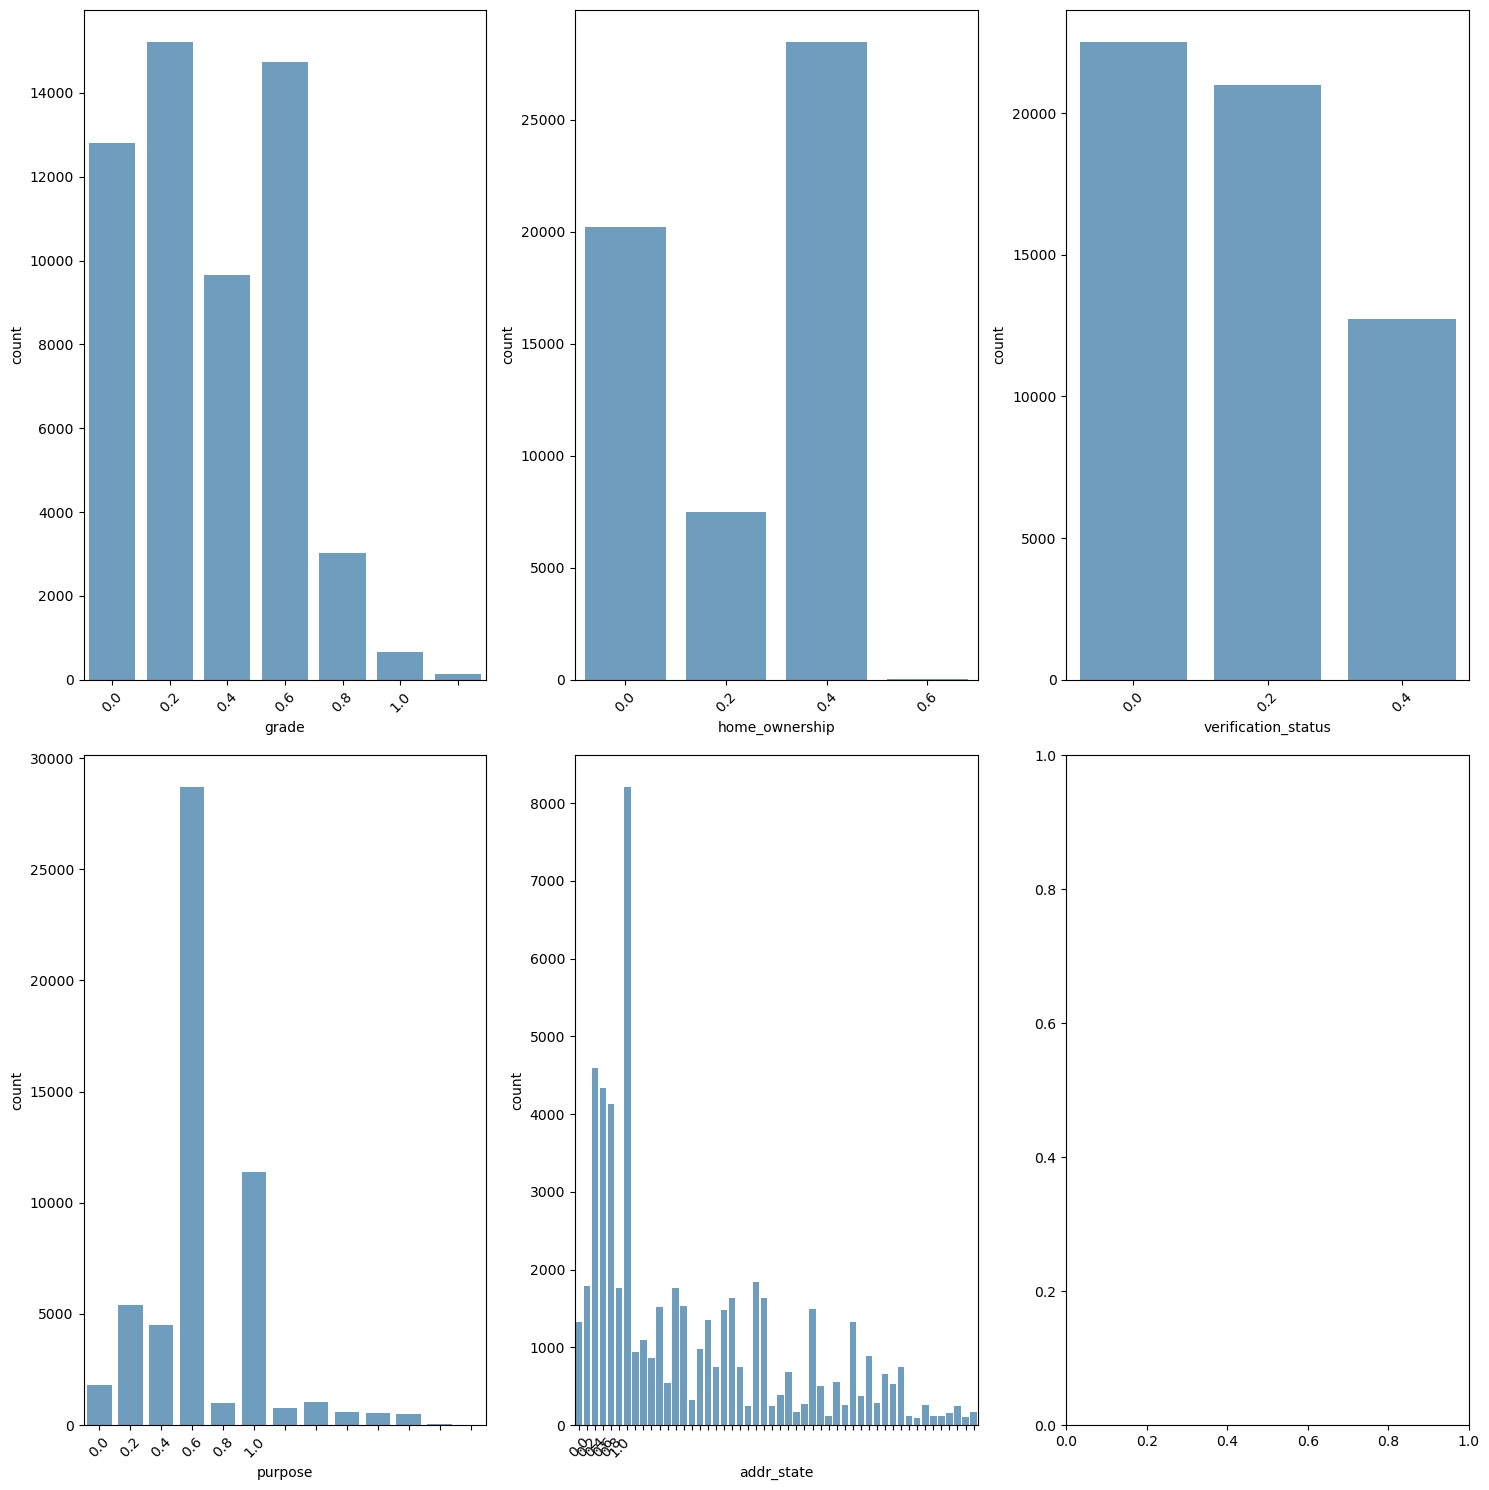

In [224]:
df_not_num = df.select_dtypes(include=['object'])
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(15, 15))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

### Numerical Variables

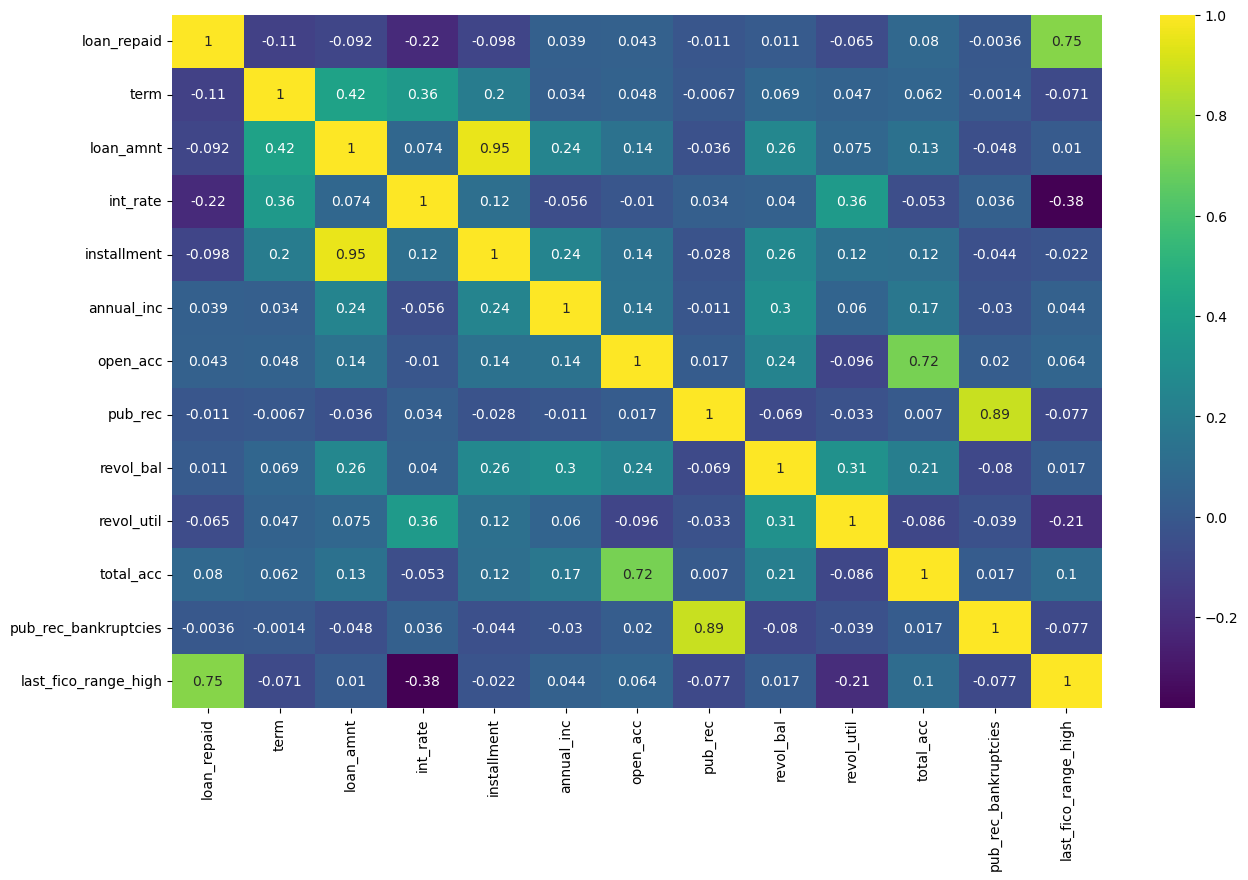

In [225]:
# Filter the DataFrame to include only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.ylim(len(corr_matrix), 0)
plt.show()

<Axes: xlabel='installment', ylabel='loan_amnt'>

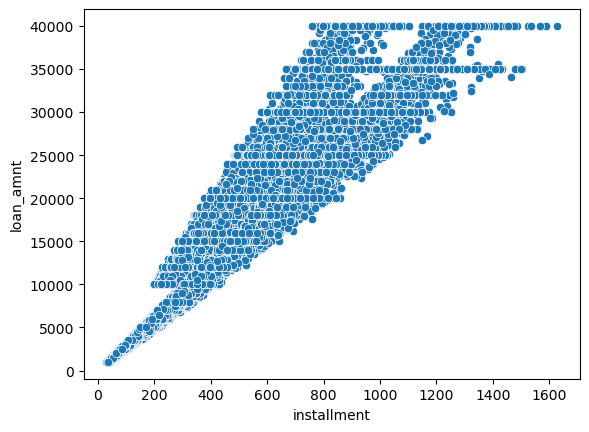

In [226]:
sns.scatterplot(x='installment',y='loan_amnt',data=df)

<span style='color:Blue'> We find a strong correlation between installment and loan_amnt;but why?

<Axes: xlabel='pub_rec_bankruptcies', ylabel='pub_rec'>

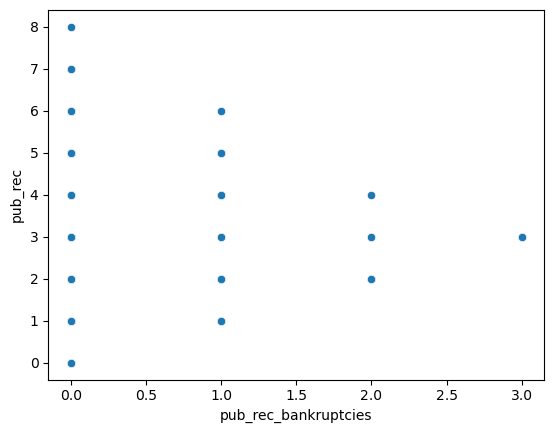

In [227]:
sns.scatterplot(x='pub_rec_bankruptcies',y='pub_rec',data=df,)

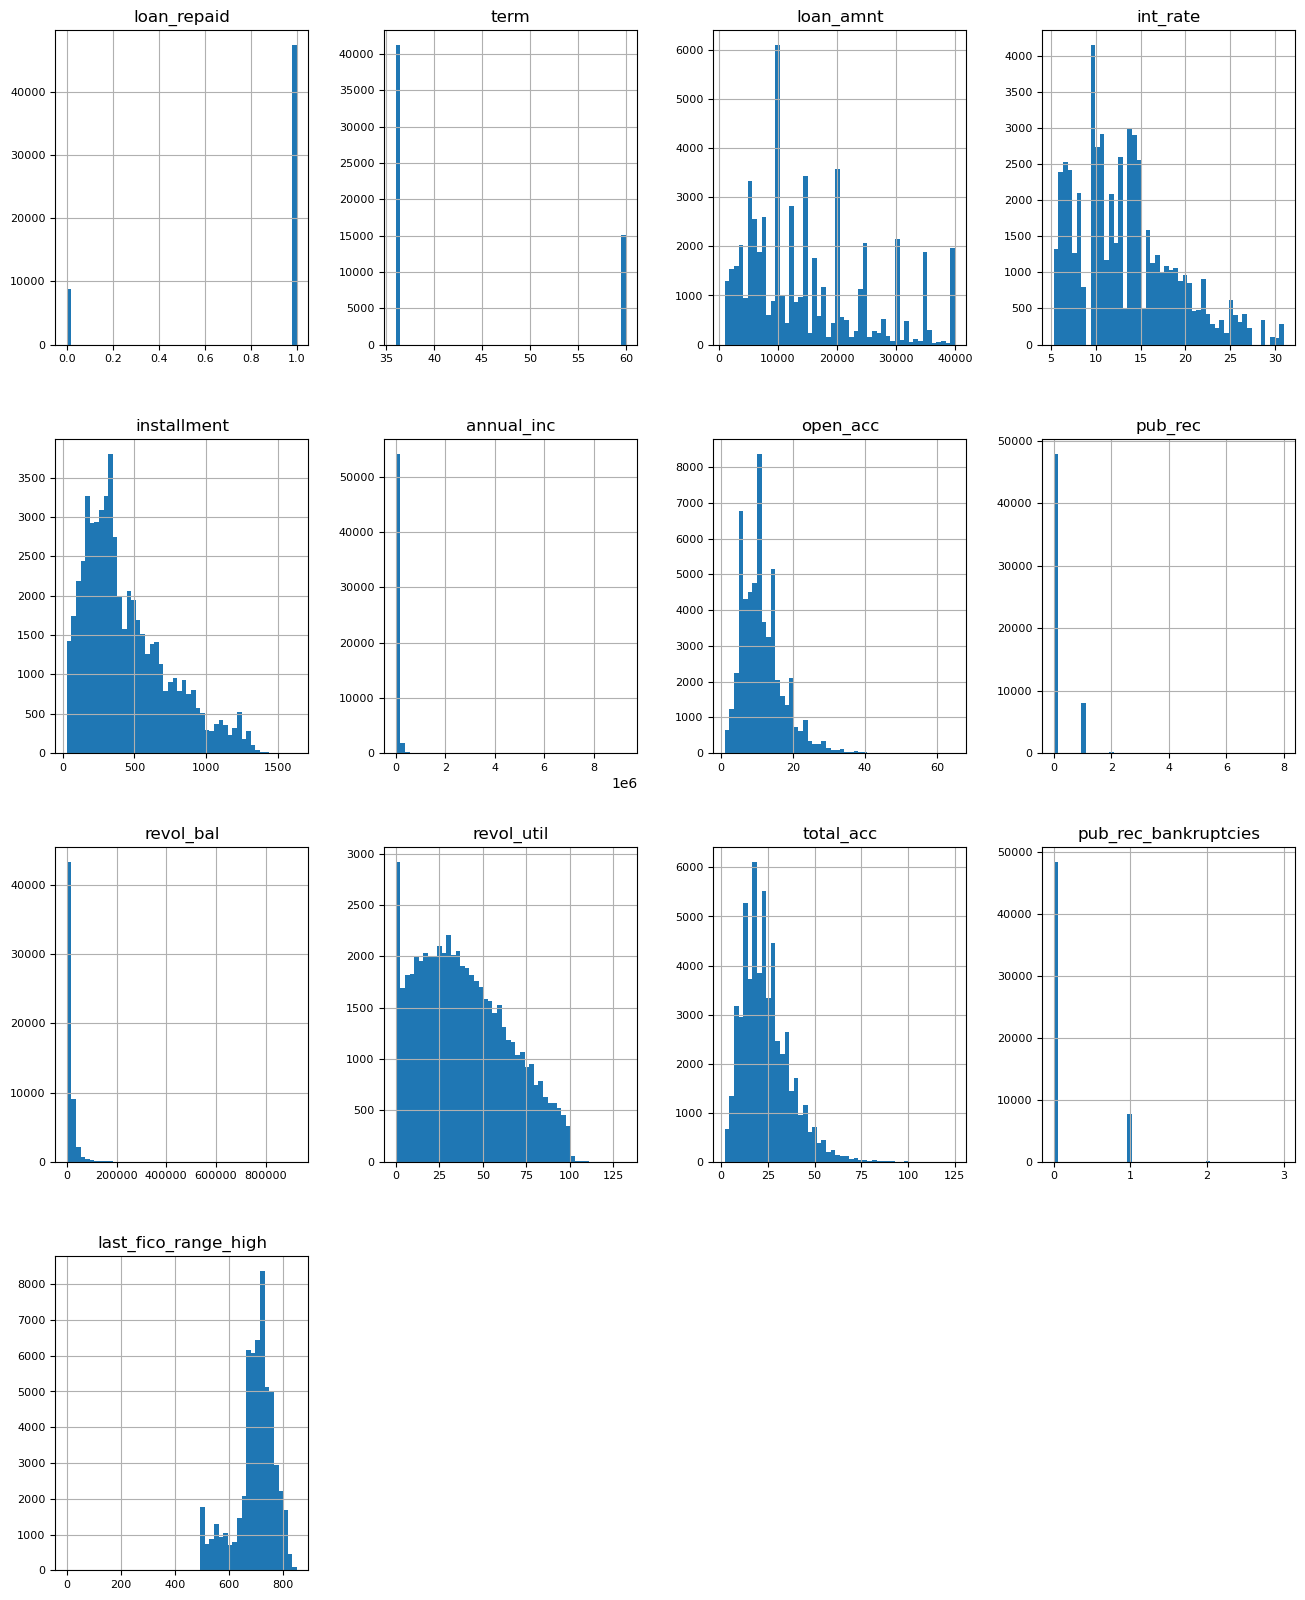

In [228]:
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Transfer catagorical variables to dummy variables 

In [229]:
# transfer catagorical varibales to dummy variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df = df.apply(le.fit_transform)
df.head()

,loan_repaid,term,grade,home_ownership,verification_status,purpose,addr_state,loan_amnt,int_rate,installment,annual_inc,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,last_fico_range_high
421101,1,0,0,3,1,5,46,73,14,956,2179,6,0,140,5,28,0,54
421113,1,0,1,2,0,8,10,144,45,2082,2379,13,1,10675,339,22,1,37
421120,1,0,1,0,2,3,42,223,45,3140,1373,12,0,4765,360,27,0,30
421135,1,0,3,2,2,2,9,1064,83,11988,2513,10,0,20995,532,24,0,41
421137,1,1,3,2,1,4,33,744,80,8231,3851,14,0,13230,342,25,0,33


In [230]:
df.shape

(56237, 18)

### Split the Data & Standardization - Feature Scaling

In [231]:
# split the data randomly into 70% training data and 30% test data.
from sklearn.model_selection import train_test_split
# split the data randomly into 70% training data and 30% test data.
X = df.drop('loan_repaid', axis = 1)
y = df['loan_repaid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [232]:
# Feature Scaling - only on the training data and not on test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 3. Modeling

### Random Forest

In [233]:
from sklearn import ensemble
params = {
    'max_features': 6,
    'n_estimators': 100, # 100 trees in the forest
    'max_depth': 100, # maximum depth of the tree is 100
    'criterion': "gini",
    'n_jobs': -1,
    'min_samples_leaf': 1
    
}
rf_model = ensemble.RandomForestClassifier(**params)

In [234]:
# fit the data
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, max_features=6, n_jobs=-1)

#### RF Cross-Validation

In [235]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation and get the scores
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Print the cross-validated scores
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", cv_scores.mean())
print("Standard deviation of cross-validated score:", cv_scores.std())

Cross-validated scores: [0.96265718 0.96634066 0.96329226 0.96621364 0.9627842 ]
Mean cross-validated score: 0.9642575892290106
Standard deviation of cross-validated score: 0.0016630902886658515


#### RF Result

In [236]:
print('Training accuracy of RF:', rf_model.score(X_train, y_train))
print('Test accuracy of RF:', rf_model.score(X_test, y_test))

Training accuracy of RF: 1.0
Test accuracy of RF: 0.963371266002845


              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2709
           1       0.97      0.99      0.98     14163

    accuracy                           0.96     16872
   macro avg       0.95      0.91      0.93     16872
weighted avg       0.96      0.96      0.96     16872



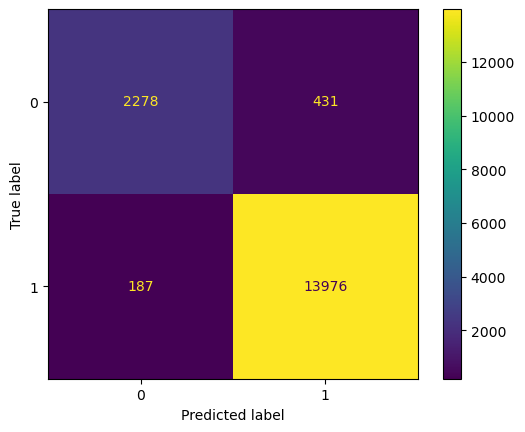

In [237]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,confusion_matrix
import matplotlib.pyplot as plt

# Assuming rf_model is your trained RandomForest model, and X_test and y_test are your test data
preds = rf_model.predict(X_test)

# Print classification report
print(classification_report(y_test, preds))

# Create confusion matrix
cm = confusion_matrix(y_test, preds)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap='viridis')
plt.show()

In [238]:
from sklearn.metrics import roc_auc_score
# auc scores
auc_score = roc_auc_score(y_test, preds)
# calculate AUC
print('AUC: %.3f' % auc_score)

AUC: 0.914


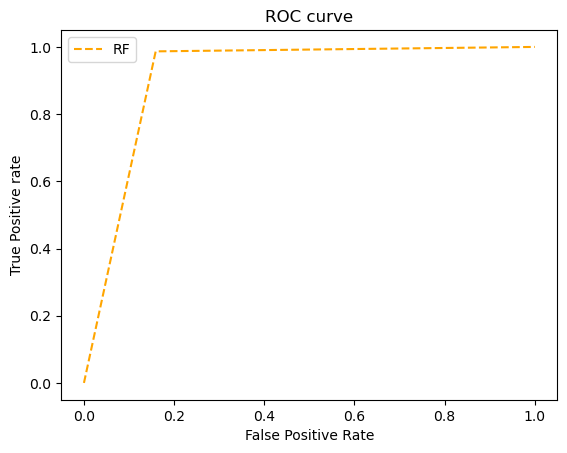

In [239]:
# calculate roc curves
from sklearn.metrics import roc_curve
fpr1, tpr1, thresh1 = roc_curve(y_test,preds, pos_label=1)
# plot the roc curve for the model
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='RF')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

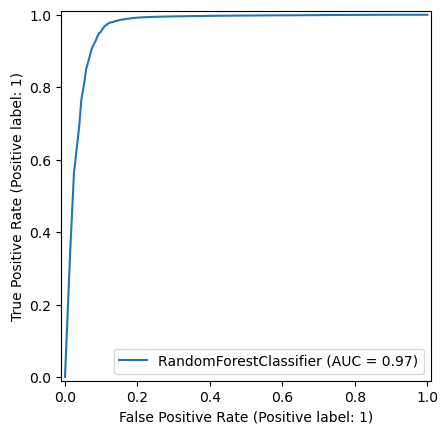

In [240]:
from sklearn.metrics import RocCurveDisplay

# Plot ROC curve using RocCurveDisplay
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)

In [241]:
# importances of variables 
feat_labels = list(df.columns)
feat_labels.remove('loan_repaid')

variable = feat_labels
importances = rf_model.feature_importances_.tolist()
dic = {"variable":variable, "importances":importances }
show = pd.DataFrame(dic).sort_values(by = "importances", ascending = False)
show.head(18)

,variable,importances
16,last_fico_range_high,0.747124
7,int_rate,0.029844
8,installment,0.026953
12,revol_bal,0.026465
9,annual_inc,0.026171
13,revol_util,0.025407
14,total_acc,0.019975
6,loan_amnt,0.019394
5,addr_state,0.017302
10,open_acc,0.015403


In [242]:
show.to_csv('file_name.csv')

### Neural network

In [243]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='lbfgs',alpha = 0.0001,
                    hidden_layer_sizes=(10, 10, 10), max_iter=1000)
nn_model.fit(X_train, y_train)

/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, solver='lbfgs')

#### NN Cross-Validation

In [244]:
# Perform 5-fold cross-validation and get the scores
cv_scores = cross_val_score(nn_model, X_train, y_train, cv=5)

# Print the cross-validated scores
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", cv_scores.mean())
print("Standard deviation of cross-validated score:", cv_scores.std())

/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWa

Cross-validated scores: [0.96011686 0.96481646 0.96240315 0.96227613 0.9620221 ]
Mean cross-validated score: 0.9623269401752825
Standard deviation of cross-validated score: 0.0014955606279217686


/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### NN Result

In [245]:
print('Training accuracy of NN:', nn_model.score(X_train, y_train))
print('Test accuracy of NN:', nn_model.score(X_test, y_test))

Training accuracy of NN: 0.9680680807824209
Test accuracy of NN: 0.9618302513039355


              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2709
           1       0.97      0.99      0.98     14163

    accuracy                           0.96     16872
   macro avg       0.94      0.91      0.93     16872
weighted avg       0.96      0.96      0.96     16872



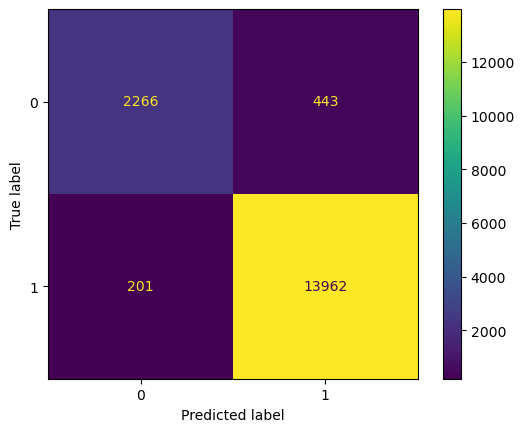

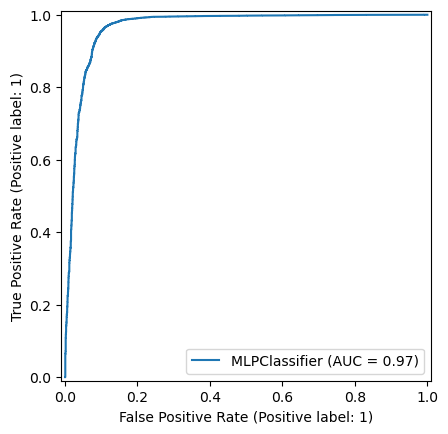

In [246]:
preds = nn_model.predict(X_test)

# Print classification report
print(classification_report(y_test, preds))

# Create confusion matrix
cm = confusion_matrix(y_test, preds)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap='viridis')
plt.show()

# Plot ROC curve using RocCurveDisplay
RocCurveDisplay.from_estimator(nn_model, X_test, y_test)
plt.show()

### Logistic Regression

#### Implementing the model

In [247]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.148312
         Iterations 8
                           Results: Logit
Model:                Logit             Method:            MLE       
Dependent Variable:   loan_repaid       Pseudo R-squared:  0.659     
Date:                 2024-07-09 09:01  AIC:               16715.2622
No. Observations:     56237             BIC:               16867.1968
Df Model:             16                Log-Likelihood:    -8340.6   
Df Residuals:         56220             LL-Null:           -24484.   
Converged:            1.0000            LLR p-value:       0.0000    
No. Iterations:       8.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
term                 -0.8026   0.0656 -12.2338 0.0000 -0.9312 -0.6741
grade           

In [248]:
df2 = df
import scipy.stats as stats
df2.annual_inc = stats.zscore(df2.annual_inc)
df2.revol_bal = stats.zscore(df2.revol_bal)

In [249]:
X2 = df2.drop('loan_repaid', axis = 1)#.to_numpy()
y2 = df2['loan_repaid'].to_numpy()

import statsmodels.api as sm
logit_model=sm.Logit(y2,X2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.143430
         Iterations 8
                           Results: Logit
Model:                Logit             Method:            MLE       
Dependent Variable:   y                 Pseudo R-squared:  0.671     
Date:                 2024-07-09 09:01  AIC:               16166.1673
No. Observations:     56237             BIC:               16318.1019
Df Model:             16                Log-Likelihood:    -8066.1   
Df Residuals:         56220             LL-Null:           -24484.   
Converged:            1.0000            LLR p-value:       0.0000    
No. Iterations:       8.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
term                 -0.8198   0.0672 -12.2060 0.0000 -0.9514 -0.6881
grade           

#### Logistic Regression

In [250]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

#### Log Cross-Validation

In [251]:
# Perform 5-fold cross-validation and get the scores
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)

# Print the cross-validated scores
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", cv_scores.mean())
print("Standard deviation of cross-validated score:", cv_scores.std())

Cross-validated scores: [0.9627842  0.96646767 0.96316525 0.96595961 0.9620221 ]
Mean cross-validated score: 0.9640797662898514
Standard deviation of cross-validated score: 0.001788000950567015


#### Log Result

In [252]:
print('Training accuracy of LR:', logreg.score(X_train, y_train))
print('Test accuracy of LR:', logreg.score(X_test, y_test))

Training accuracy of LR: 0.9641051695668741
Test accuracy of LR: 0.9630749170222854


              precision    recall  f1-score   support

           0       0.94      0.82      0.88      2709
           1       0.97      0.99      0.98     14163

    accuracy                           0.96     16872
   macro avg       0.95      0.91      0.93     16872
weighted avg       0.96      0.96      0.96     16872



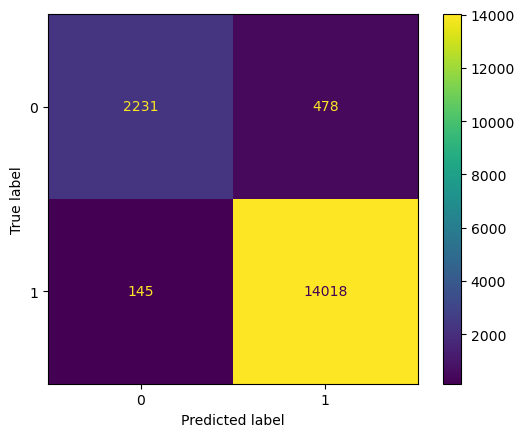

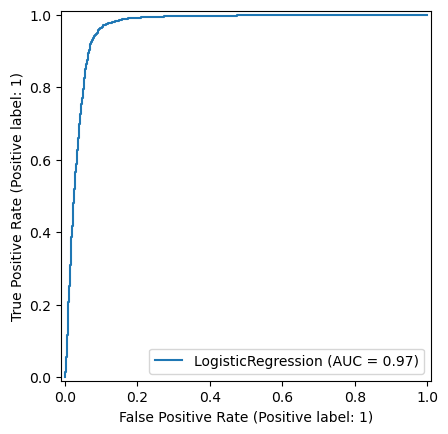

In [253]:
# result and solution
preds = logreg.predict(X_test)

# Print classification report
print(classification_report(y_test, preds))

# Create confusion matrix
cm = confusion_matrix(y_test, preds)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap='viridis')
plt.show()

# Plot ROC curve using RocCurveDisplay
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.show()

In [254]:
from sklearn.metrics import roc_auc_score
# auc scores
auc_score = roc_auc_score(y_test, preds)
# calculate AUC
print('AUC: %.3f' % auc_score)

AUC: 0.907


### SVM -- LinearSVC (linear kernel)

In [255]:
from sklearn import svm
C = 0.1
ls2 = svm.LinearSVC(C=C, max_iter=10000).fit(X_train, y_train)

/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


#### SVM Cross-Validation

In [256]:
# Perform 5-fold cross-validation and get the scores
cv_scores = cross_val_score(ls2, X_train, y_train, cv=5)

# Print the cross-validated scores
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", cv_scores.mean())
print("Standard deviation of cross-validated score:", cv_scores.std())

/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wenweiwu/miniconda3/envs/575/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress th

Cross-validated scores: [0.96265718 0.96646767 0.96329226 0.96519751 0.96087895]
Mean cross-validated score: 0.9636987171345105
Standard deviation of cross-validated score: 0.001955227375068605


#### SVM Result

In [257]:
print('Training accuracy of SVM:', ls2.score(X_train, y_train))
print('Test accuracy of SVM:', ls2.score(X_test, y_test))

Training accuracy of SVM: 0.9637749269655785
Test accuracy of SVM: 0.9620673304883831


              precision    recall  f1-score   support

           0       0.94      0.81      0.87      2709
           1       0.97      0.99      0.98     14163

    accuracy                           0.96     16872
   macro avg       0.95      0.90      0.93     16872
weighted avg       0.96      0.96      0.96     16872



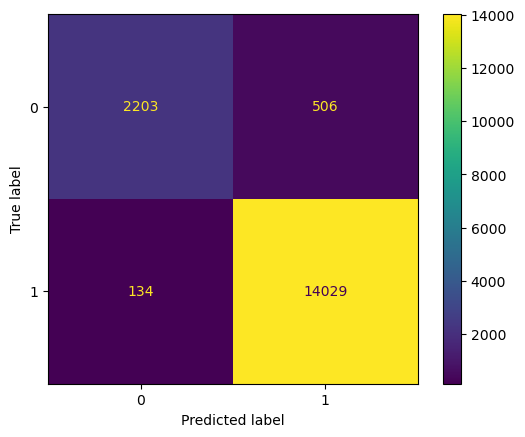

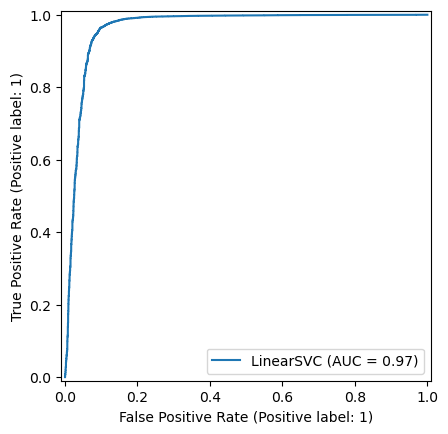

In [258]:
# result and solution
preds = ls2.predict(X_test)

# Print classification report
print(classification_report(y_test, preds))

# Create confusion matrix
cm = confusion_matrix(y_test, preds)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap='viridis')
plt.show()

# Plot ROC curve using RocCurveDisplay (if applicable)
RocCurveDisplay.from_estimator(ls2, X_test, y_test)
plt.show()

In [259]:
from sklearn.metrics import roc_auc_score
# auc scores
auc_score = roc_auc_score(y_test, preds)
# calculate AUC
print('AUC: %.3f' % auc_score)

AUC: 0.902


### KNN

In [260]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

#### KNN Cross-Validation

In [261]:
# Perform 5-fold cross-validation and get the scores
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)

# Print the cross-validated scores
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", cv_scores.mean())
print("Standard deviation of cross-validated score:", cv_scores.std())

Cross-validated scores: [0.94550997 0.95186079 0.9472882  0.94550997 0.94284263]
Mean cross-validated score: 0.946602311698209
Standard deviation of cross-validated score: 0.0029880992663599798


#### KNN Result

In [262]:
print('Training accuracy of KNN:', classifier.score(X_train, y_train))
print('Test accuracy of KNN:', classifier.score(X_test, y_test))

Training accuracy of KNN: 0.958541851898895
Test accuracy of KNN: 0.9460052157420579


              precision    recall  f1-score   support

           0       0.95      0.70      0.81      2709
           1       0.95      0.99      0.97     14163

    accuracy                           0.95     16872
   macro avg       0.95      0.85      0.89     16872
weighted avg       0.95      0.95      0.94     16872



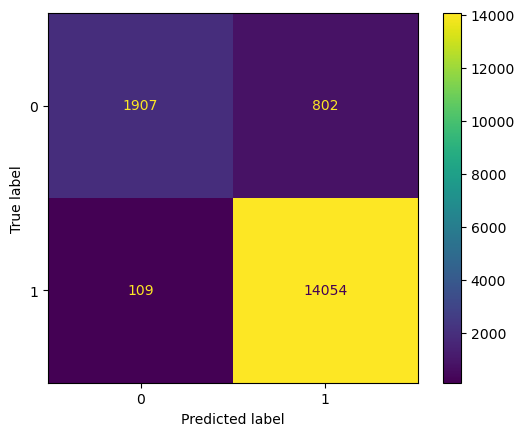

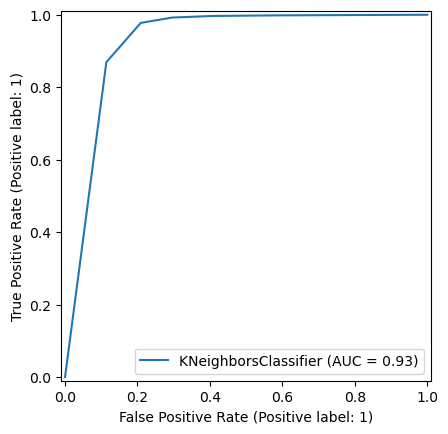

In [263]:
# result and solution
preds = classifier.predict(X_test)

# Print classification report
print(classification_report(y_test, preds))

# Create confusion matrix
cm = confusion_matrix(y_test, preds)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap='viridis')
plt.show()

# Plot ROC curve using RocCurveDisplay (if applicable)
RocCurveDisplay.from_estimator(classifier, X_test, y_test)
plt.show()

In [264]:
from sklearn.metrics import roc_auc_score
# auc scores
auc_score = roc_auc_score(y_test, preds)
# calculate AUC
print('AUC: %.3f' % auc_score)

AUC: 0.848


#### Application
- find the potential neighbors of a customer to see the proportion of "charged off" and "fully paid" in order to decide whether we should borrow the money to him.
- For example, randomly get 11 rows of the data.
- Since the dimensions of our data are high, we decide to reduce the dimensions

In [265]:
random_data = df.sample(n = 51)
random_data.head()

,loan_repaid,term,grade,home_ownership,verification_status,purpose,addr_state,loan_amnt,int_rate,installment,annual_inc,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,last_fico_range_high
485241,1,0,2,3,2,1,41,273,66,4354,0.466085,10,1,0.328789,389,20,1,45
841773,1,0,2,3,2,8,4,519,69,7897,-0.424192,5,0,-1.050932,455,6,0,31
783721,1,0,3,0,0,2,30,144,84,2461,-2.062219,4,0,0.919291,925,6,0,32
815414,1,0,0,0,0,5,18,612,8,7942,1.343968,8,0,-1.333023,6,13,0,71
1588774,1,0,0,3,0,2,39,109,9,1454,-1.885953,4,0,-0.970316,305,9,0,39


In [266]:
random_data2 = random_data.to_numpy()

In [267]:
from csv import reader
from math import sqrt


def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(1, len(row1)):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)
 
# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors
 
# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[0] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction
 

prediction = predict_classification(random_data2, random_data2[0], 10)
print('Expected %d, Got %d.' % (random_data2[0][0], prediction))

Expected 1, Got 1.


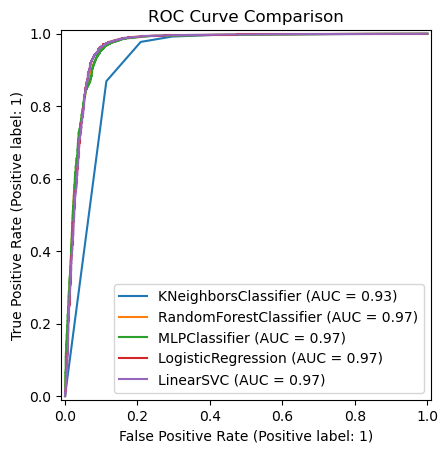

In [268]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Plot ROC curve for the first classifier
knn_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test)
ax = knn_disp.ax_

# Plot ROC curve for the second classifier on the same axes
rf_disp = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax)

# Plot ROC curve for the third classifier on the same axes
nn_disp = RocCurveDisplay.from_estimator(nn_model, X_test, y_test, ax=ax)

# Plot ROC curve for the fourth classifier on the same axes
lr_disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test, ax=ax)

# Plot ROC curve for the fifth classifier on the same axes
svm_disp = RocCurveDisplay.from_estimator(ls2, X_test, y_test, ax=ax)

# Set the title for the figure
ax.set_title("ROC Curve Comparison")

plt.show()
